In [1]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=3ab8a7b8c2444dbe0a8f8e47fe9e74f1fc7fe6bf9a45961eb0c4825c09a3d3b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ks7b7yga/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import en_core_web_lg

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
#Importing packages for later
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
from matplotlib.font_manager import FontProperties
import re


In [46]:
#Read in the scrape results
rgame = pd.read_csv('rgames_comments.csv')#,sep = '\t')
#Read in the ps5 xbox csv file. 
model_brand = pd.read_csv('ps5_xbox.csv', header = None, sep=',')
model_brand.columns = ['brand','model']
#names = ['brand','model'], sep=',')
rgame[:5]

,submission,author,body,score,created,url_of_post
0,ipfelj,Smallgenie549,"PS5 has to be $500 too, right?",1567,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...
1,ipfelj,niallmul97,"As a PC guy with no real horse in this race, t...",5805,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...
2,ipfelj,narutomaki,Well there it is. It's nice to know the releas...,822,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...
3,ipfelj,LIGHT_COLLUSION,Did my coffee not kick in yet or is EA Play no...,1585,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...
4,ipfelj,firesyrup,I'm surprised they didn't wait for Sony to rev...,384,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...


In [47]:
model_brand

,brand,model
0,xbox,xbox series one x
1,xbox,xbox series one
2,xbox,xbox one
3,xbox,xbox series one s
4,xbox,xbox series 1x
5,xbox,xbox series 1s
6,xbox,xbox series x
7,xbox,xbox series s
8,xbox,xbox 1
9,xbox,xbox 1x


In [48]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from nltk import pos_tag, word_tokenize
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
## Create dictionary for model to brand mapping
model_brand = model_brand.set_index('model')
model_brand_dict = model_brand["brand"].to_dict()

In [50]:
stop = stopwords.words('english')

rgame["body"] = rgame["body"].astype(str)
rgame["comments_tokens"] = rgame["body"].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
rgame["comments_tokens"] = rgame["comments_tokens"].apply(lambda list_of_words: [x if x not in model_brand_dict else model_brand_dict[x] for x in list_of_words])
rgame["comments_tokens"] = rgame["comments_tokens"].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])


In [51]:
## Get all the unique tokens in each comments
rgame["comments_unique"] = rgame["comments_tokens"].apply(lambda x: sorted(set(x)))
rgame

,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique
0,ipfelj,Smallgenie549,"PS5 has to be $500 too, right?",1567,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[ps5, 500, right]","[500, ps5, right]"
1,ipfelj,niallmul97,"As a PC guy with no real horse in this race, t...",5805,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[pc, guy, real, horse, race, insane, amount, p...","[499, amount, guy, horse, insane, interested, ..."
2,ipfelj,narutomaki,Well there it is. It's nice to know the releas...,822,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[well, nice, know, release, date, also, kind, ...","[also, date, decided, due, dump, f, feels, inf..."
3,ipfelj,LIGHT_COLLUSION,Did my coffee not kick in yet or is EA Play no...,1585,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[coffee, kick, yet, ea, play, included, gpu, p...","[09, 10, 100, 2, 20, 2020, 60, able, addition,..."
4,ipfelj,firesyrup,I'm surprised they didn't wait for Sony to rev...,384,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[surprised, wait, sony, reveal, price, ps5, he...","[chicken, glad, headstart, phase, price, ps5, ..."
...,...,...,...,...,...,...,...,...
6073,j4wsgi,ketchup92,"No the PS4 was always loud, especially the fir...",217,1.601812e+09,/r/Games/comments/j4wsgi/playstation_5_first_i...,"[ps4, always, loud, especially, first, units, ...","[always, applied, bunch, especially, first, lo..."
6074,j4wsgi,Titan7771,Apparently these reviewers can’t even take pic...,60,1.601816e+09,/r/Games/comments/j4wsgi/playstation_5_first_i...,"[apparently, reviewers, even, take, pictures, ...","[allowed, apparently, back, bizarre, even, lik..."
6075,j4wsgi,tymandude1,Apparently the only way you're allowed to impl...,59,1.601816e+09,/r/Games/comments/j4wsgi/playstation_5_first_i...,"[apparently, way, allowed, implement, gyro, ei...","[allowed, apparently, day, designed, disregard..."
6076,j4wsgi,varnums1666,"I, for one, loved having a very big map button.",51,1.601835e+09,/r/Games/comments/j4wsgi/playstation_5_first_i...,"[one, loved, big, map, button]","[big, button, loved, map, one]"


##Lift analysis of brands

In [52]:
## Get frequency of all words
all_words = rgame['comments_unique'].sum()
freq_dist = nltk.FreqDist(all_words)

In [53]:
## Get the frequency counts of all brands
all_brands_dict = {your_key: freq_dist[your_key] for your_key in freq_dist.keys() if your_key in model_brand_dict.values()}
all_brands = pd.DataFrame.from_dict(all_brands_dict, orient='index').reset_index()
all_brands.columns = ["brand","word_frequency"]
all_brands.sort_values("word_frequency", ascending= False, inplace=True)

###ranking

In [54]:
## Display the brands ranking by frequency count
top_brands = all_brands.head(3)
top10 = all_brands.head(3)
top_brands

,brand,word_frequency
2,xbox,358
0,ps5,271
1,pc,232


In [13]:
rgame.head()

,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique
0,ipfelj,Smallgenie549,"PS5 has to be $500 too, right?",1567,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[ps5, 500, right]","[500, ps5, right]"
1,ipfelj,niallmul97,"As a PC guy with no real horse in this race, t...",5805,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[pc, guy, real, horse, race, insane, amount, p...","[499, amount, guy, horse, insane, interested, ..."
2,ipfelj,narutomaki,Well there it is. It's nice to know the releas...,822,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[well, nice, know, release, date, also, kind, ...","[also, date, decided, due, dump, f, feels, inf..."
3,ipfelj,LIGHT_COLLUSION,Did my coffee not kick in yet or is EA Play no...,1585,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[coffee, kick, yet, ea, play, included, gpu, p...","[09, 10, 100, 2, 20, 2020, 60, able, addition,..."
4,ipfelj,firesyrup,I'm surprised they didn't wait for Sony to rev...,384,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[surprised, wait, sony, reveal, price, ps5, he...","[chicken, glad, headstart, phase, price, ps5, ..."


###lift function


In [55]:
def calculate_lift(a, b, tokenized_posts):
    num_a = 0
    num_b = 0
    num_a_b = 0
    n = len(tokenized_posts)
    if a==b:
        return 1
    for i in tokenized_posts:
        if a in i:
            num_a += 1
        if b in i:
            num_b += 1
        if a in i and b in i:
            num_a_b += 1
    if num_a == 0:
        return (float(n)*num_a_b)/(num_b)
    elif num_b == 0:
        return (float(n)*num_a_b)/(num_a)
    else:
        return (float(n)*num_a_b)/(num_a*num_b)

In [56]:
## Get the lift scores for the top-10 brands
num_brands = 3

## print(top_brands)
top_brands = top_brands.head(num_brands)
lift_brands = []
for index, brand_a in top_brands.iterrows():
    for index, brand_b in top_brands.iterrows():
        lift_brands.append(calculate_lift(brand_a.brand, brand_b.brand, rgame.comments_unique))

In [57]:
lift_brands_df = np.reshape(lift_brands,(num_brands,num_brands))

### console to console Lift Matrix

In [58]:
lift_brands = pd.DataFrame(data= lift_brands_df)

for i in range(3):
    lift_brands = lift_brands.rename(columns = {i: top_brands.iloc[i, 0]})
    lift_brands = lift_brands.rename(index = {i: top_brands.iloc[i, 0]})
lift_brands

,xbox,ps5,pc
xbox,1.000000,3.633594,4.756670
ps5,3.633594,1.000000,2.996851
pc,4.756670,2.996851,1.000000


###MDS plot

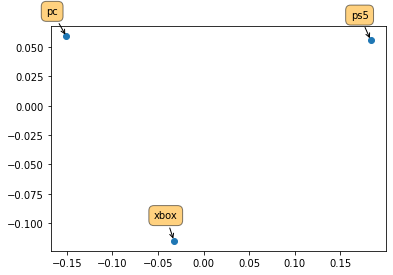

In [18]:
## Calculating the dissimilarity matrix which is the input for plotting MDS plot
dissimilarity_matrix = 1/lift_brands
np.fill_diagonal(dissimilarity_matrix.values, 0)

## Plotting MDS plot
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(lift_brands, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points',ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'orange', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

##Attribute Analysis using lift

In [59]:
attribute_list = ['performance','graphics','affordable','favorite','buy','speed',
                 'price','security','fps','games','multiplayer','online','subscription',
                  'quality']
attr_df = pd.DataFrame(index = attribute_list)
attr_df['synonym'] = attribute_list
attr_df[:5]

,synonym
performance,performance
graphics,graphics
affordable,affordable
favorite,favorite
buy,buy


In [60]:
attr_dict = attr_df["synonym"].to_dict()
rgame["attr_tokens"] = rgame["comments_unique"].apply(lambda list_of_words: [attr_dict[x] for x in list_of_words if x in attr_dict  ])

In [61]:
# Define consoles by frequency obtained previously
import numpy as np
top_brands=['xbox','ps5','pc']

# Get unique list of grouped attribute names
uniq_attr=np.unique(attr_df['synonym'])
uniq_attr

array(['affordable', 'buy', 'favorite', 'fps', 'games', 'graphics',
       'multiplayer', 'online', 'performance', 'price', 'quality',
       'security', 'speed', 'subscription'], dtype=object)

In [62]:
# Find top 5 attributes:

def calc_freq(tokenized_posts,find_list):
    freq_a=0
    for i in tokenized_posts:
        if find_list in i:
            freq_a += 1
    return freq_a
  
# Calculate freq for attr
df_top_attr=pd.DataFrame(columns=['attribute','freq'])
for i,attr in enumerate(uniq_attr):
        temp_freq=calc_freq( rgame.comments_unique,str(attr))
        df_top_attr.loc[i]=[str(attr),temp_freq]

In [63]:
top_attr=df_top_attr.sort_values(by='freq',ascending=False).head(5)
top_attr['attribute']

4           games
1             buy
9           price
10        quality
6     multiplayer
Name: attribute, dtype: object

In [64]:
# Grouped Brands and attribute lifts 
df_lift_brand_attr=pd.DataFrame(columns=['brand','attribute','lift'])
i=0
for  brand_a in top_brands:
    for attr in top_attr['attribute']:
        temp_lift=calculate_lift(str(brand_a), str(attr), rgame.comments_unique)
        df_lift_brand_attr.loc[i]=[ str(brand_a),str(attr),temp_lift]
        i=i+1

In [65]:
df1 = df_lift_brand_attr.sort_values('lift',ascending = False).groupby('brand').head(10)
print(df1.sort_values(['brand','lift'],ascending=[True,False]))

   brand    attribute      lift
14    pc  multiplayer  2.652990
13    pc      quality  2.060539
11    pc          buy  1.920292
12    pc        price  1.827787
10    pc        games  1.625732
6    ps5          buy  3.875002
7    ps5        price  2.260191
5    ps5        games  1.756825
8    ps5      quality  0.504001
9    ps5  multiplayer  0.283899
2   xbox        price  2.368975
4   xbox  multiplayer  1.719256
1   xbox          buy  1.599988
0   xbox        games  1.398972
3   xbox      quality  1.144561


In [66]:
lift_matrix = df1.pivot(index='brand', columns='attribute')
lift_matrix

lift                                          
attribute       buy     games multiplayer     price   quality
brand                                                        
pc         1.920292  1.625732    2.652990  1.827787  2.060539
ps5        3.875002  1.756825    0.283899  2.260191  0.504001
xbox       1.599988  1.398972    1.719256  2.368975  1.144561

##Aspiration Analysis

In [67]:
aspiration_list = ['wish to', 'hope to', 'want to', 'really want', 'prefer', 'dream graphics', 'dream of', 'aspire', 'looking for', 'looking to', 'would like', 'can afford', 'looking at', 'pre order','pre_order', 'cop']

In [68]:
aspiration = pd.DataFrame(aspiration_list)
aspiration.columns=['word']
aspiration

,word
0,wish to
1,hope to
2,want to
3,really want
4,prefer
5,dream graphics
6,dream of
7,aspire
8,looking for
9,looking to


In [69]:
## Function to replace the aspirational phrases with the word - "aspiration"
def asp_word_replace(comment):
    for i in aspiration['word'].index.values:
        comment = comment.lower().replace(aspiration['word'][i],'aspiration')
    return comment

In [70]:
rgame["comments_replace"] = rgame["body"].apply(asp_word_replace)

In [71]:
## Tokenize the comments and remove stop words after replacing the phrases by aspiration
rgame["comments_replace_tokens"] = rgame["comments_replace"].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
rgame["comments_replace_tokens"] = rgame["comments_replace_tokens"].apply(lambda list_of_words: [x if x not in model_brand_dict else model_brand_dict[x] for x in list_of_words])
rgame["comments_replace_tokens"] = rgame["comments_replace_tokens"].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])
rgame["comments_replace_tokens"] = rgame["comments_replace_tokens"].apply(lambda x: sorted(set(x)))

In [72]:
## Get the lift score for all brands and aspirational words
lift_asp_brands = pd.DataFrame(columns=['Brand','Lift'])
for index, brand_a in all_brands.iterrows():
        lift_asp_brands = lift_asp_brands.append({'Brand': brand_a.brand, "Lift":calculate_lift(brand_a.brand, 'aspiration', rgame.comments_replace_tokens)},
                                        ignore_index=True)

In [73]:
lift_asp_brands.sort_values(by='Lift',ascending=False).head(5)

,Brand,Lift
2,pc,2.062856
1,ps5,1.589389
0,xbox,1.470505


Hardcore gamers would prefer to buy a PC. in just PS5 and XBOX, PS5 wins

#Sentiment Analysis


###Word frequency analysis using POS

In [34]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer # to remove punctuations
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [74]:
#clean_comment accepts a string. It then cleans the comment by removing punctuation and stopwords.
#It returns a list of words in that string.
def clean_comment(comment):
    #For cleaning up the test comment. Remove punctuation and make everything lower case.
    comment = re.sub(r'[^\w\s]','',comment.lower())
    
    #Syntax translation:
    #word can be anything. I choose word since it's what we're essentially doing
    #comment.split() converts the comment into a list. 
    #Then see if the word in that list is in the drop_stop or not. 
    #Drops any word that is in the stopwords list.
    stopwords_list = stopwords.words('english')
    #Store this list and return it.
    cleaned = [word for word in comment.split() if word not in stopwords_list]
    return cleaned

In [75]:
#Use function to create a new cleaned body column.
rgame['cleaned body'] = rgame['body'].astype(str).apply(clean_comment)

In [76]:
# Obtain POS for the tokens
nltk.download('averaged_perceptron_tagger')

rgame['pos']=rgame['cleaned body'].apply(nltk.tag.pos_tag)
rgame[:5]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique,attr_tokens,comments_replace,comments_replace_tokens,cleaned body,pos
0,ipfelj,Smallgenie549,"PS5 has to be $500 too, right?",1567,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[ps5, 500, right]","[500, ps5, right]",[],"ps5 has to be $500 too, right?","[500, ps5, right]","[ps5, 500, right]","[(ps5, NN), (500, CD), (right, NN)]"
1,ipfelj,niallmul97,"As a PC guy with no real horse in this race, t...",5805,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[pc, guy, real, horse, race, insane, amount, p...","[499, amount, guy, horse, insane, interested, ...",[],"as a pc guy with no real horse in this race, t...","[499, amount, guy, horse, insane, interested, ...","[pc, guy, real, horse, race, thats, insane, am...","[(pc, NN), (guy, NN), (real, JJ), (horse, NN),..."
2,ipfelj,narutomaki,Well there it is. It's nice to know the releas...,822,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[well, nice, know, release, date, also, kind, ...","[also, date, decided, due, dump, f, feels, inf...",[],well there it is. it's nice to know the releas...,"[also, date, decided, due, dump, f, feels, inf...","[well, nice, know, release, date, also, kind, ...","[(well, RB), (nice, RB), (know, VBP), (release..."
3,ipfelj,LIGHT_COLLUSION,Did my coffee not kick in yet or is EA Play no...,1585,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[coffee, kick, yet, ea, play, included, gpu, p...","[09, 10, 100, 2, 20, 2020, 60, able, addition,...","[games, speed]",did my coffee not kick in yet or is ea play no...,"[09, 10, 100, 2, 20, 2020, 60, able, addition,...","[coffee, kick, yet, ea, play, included, gpu, p...","[(coffee, NN), (kick, NN), (yet, RB), (ea, JJ)..."
4,ipfelj,firesyrup,I'm surprised they didn't wait for Sony to rev...,384,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[surprised, wait, sony, reveal, price, ps5, he...","[chicken, glad, headstart, phase, price, ps5, ...",[price],i'm surprised they didn't wait for sony to rev...,"[chicken, glad, headstart, phase, price, ps5, ...","[im, surprised, didnt, wait, sony, reveal, pri...","[(im, NN), (surprised, VBD), (didnt, JJ), (wai..."


In [77]:
# Extract the list of nouns
rgame['nouns']=rgame['pos'].apply(lambda pos_list: [x[0] for x in pos_list if x[1].startswith('NN')])
rgame[:5]

,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique,attr_tokens,comments_replace,comments_replace_tokens,cleaned body,pos,nouns
0,ipfelj,Smallgenie549,"PS5 has to be $500 too, right?",1567,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[ps5, 500, right]","[500, ps5, right]",[],"ps5 has to be $500 too, right?","[500, ps5, right]","[ps5, 500, right]","[(ps5, NN), (500, CD), (right, NN)]","[ps5, right]"
1,ipfelj,niallmul97,"As a PC guy with no real horse in this race, t...",5805,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[pc, guy, real, horse, race, insane, amount, p...","[499, amount, guy, horse, insane, interested, ...",[],"as a pc guy with no real horse in this race, t...","[499, amount, guy, horse, insane, interested, ...","[pc, guy, real, horse, race, thats, insane, am...","[(pc, NN), (guy, NN), (real, JJ), (horse, NN),...","[pc, guy, horse, race, thats, amount, power, i..."
2,ipfelj,narutomaki,Well there it is. It's nice to know the releas...,822,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[well, nice, know, release, date, also, kind, ...","[also, date, decided, due, dump, f, feels, inf...",[],well there it is. it's nice to know the releas...,"[also, date, decided, due, dump, f, feels, inf...","[well, nice, know, release, date, also, kind, ...","[(well, RB), (nice, RB), (know, VBP), (release...","[release, date, kind, feels, ms, fk, dump, inf..."
3,ipfelj,LIGHT_COLLUSION,Did my coffee not kick in yet or is EA Play no...,1585,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[coffee, kick, yet, ea, play, included, gpu, p...","[09, 10, 100, 2, 20, 2020, 60, able, addition,...","[games, speed]",did my coffee not kick in yet or is ea play no...,"[09, 10, 100, 2, 20, 2020, 60, able, addition,...","[coffee, kick, yet, ea, play, included, gpu, p...","[(coffee, NN), (kick, NN), (yet, RB), (ea, JJ)...","[coffee, kick, play, value, arts, game, pass, ..."
4,ipfelj,firesyrup,I'm surprised they didn't wait for Sony to rev...,384,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[surprised, wait, sony, reveal, price, ps5, he...","[chicken, glad, headstart, phase, price, ps5, ...",[price],i'm surprised they didn't wait for sony to rev...,"[chicken, glad, headstart, phase, price, ps5, ...","[im, surprised, didnt, wait, sony, reveal, pri...","[(im, NN), (surprised, VBD), (didnt, JJ), (wai...","[im, wait, sony, reveal, price, ps5, headstart..."


In [78]:
# Filter the noun list only to make the list of attributes 
noun_lst = rgame['nouns'].apply(pd.Series).stack().unique()

# Get the frequencies for the nouns
noun_df= pd.DataFrame(noun_lst)
noun_df.columns=['nouns']

# Join with frequency table and get frequency of all words
all_words = rgame['cleaned body'].sum()
freq_dist = nltk.FreqDist(all_words)

df_fdist=pd.DataFrame(list(freq_dist.items()), columns=['term', 'freq'])

noun_freq_df = pd.merge(noun_df, df_fdist, right_on='term', left_on='nouns')
noun_freq_df[:10]

,nouns,term,freq
0,ps5,ps5,253
1,right,right,216
2,pc,pc,261
3,guy,guy,90
4,horse,horse,11
5,race,race,13
6,thats,thats,495
7,amount,amount,68
8,power,power,59
9,ill,ill,137


Not much to be gained from looking at the word frequency 

##Sentiment Analysis

In [80]:
model_brand = pd.read_csv('ps5_xbox.csv', header = None, sep=',')
model_brand.columns = ['brand','model']
prelim_dict = model_brand.set_index('model').to_dict('index')
model_to_brand_dict = {}
#Iterate over the prelim dictionary to make a new one.
for key,value in prelim_dict.items():
    for key1, value1 in value.items():
        model_to_brand_dict[key] = value1
        

In [81]:
#Function to replace all of the car models with car brands.
#Part 2 of cleaning comments.
#Could merge into clean comment but I feel this is more clear.
#model_to_brand takes a list of words as a parameter and a model_to_brand_dict.
#It then iterates over the list and sees if each word matches a key in the dictionary. 
#If the word is in the dictionary, it will be converted to a brand.
#Specifically, dict[key] gives the value of that key. In this case model: brand.
#Returns the word list converted 
def model_to_brand(word_list,word_dict=model_to_brand_dict):
    #Need initial index of -1 to get index 0 for the iteration
    index = -1
    for word in word_list: #Iterate for every word in the list
        index += 1
        if word in model_to_brand_dict: #word is a key in the dictionary
            #Convert key to value. Model to brand.
            word_list[index] = model_to_brand_dict[word]
    return word_list

In [82]:
#Using function to replace models with brands
rgame['cleaned body'] = rgame['cleaned body'].map(model_to_brand)
maskx = rgame['cleaned body'].str.contains('xbox',regex=False) == True
rgamex = rgame[maskx]
rgamex


,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique,attr_tokens,comments_replace,comments_replace_tokens,cleaned body,pos,nouns
3,ipfelj,LIGHT_COLLUSION,Did my coffee not kick in yet or is EA Play no...,1585,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[coffee, kick, yet, ea, play, included, gpu, p...","[09, 10, 100, 2, 20, 2020, 60, able, addition,...","[games, speed]",did my coffee not kick in yet or is ea play no...,"[09, 10, 100, 2, 20, 2020, 60, able, addition,...","[coffee, kick, yet, ea, play, included, gpu, p...","[(coffee, NN), (kick, NN), (yet, RB), (ea, JJ)...","[coffee, kick, play, value, arts, game, pass, ..."
6,ipfelj,IISuperSlothII,"Thank fuck the game of chicken is over, can we...",1998,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[thank, fuck, game, chicken, get, back, showin...","[350, 450, actually, albeit, back, chicken, de...",[games],"thank fuck the game of chicken is over, can we...","[350, 450, actually, albeit, back, chicken, de...","[thank, fuck, game, chicken, get, back, showin...","[(thank, JJ), (fuck, JJ), (game, NN), (chicken...","[game, chicken, games, sony, try, middle, grou..."
14,ipfelj,IrishBros91,Honestly xbox is smashing this so much value f...,123,1.599659e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[honestly, xbox, smashing, much, value, gamers...","[casual, consoles, etc, game, gamers, honestly...",[],honestly xbox is smashing this so much value f...,"[casual, consoles, etc, game, gamers, honestly...","[honestly, xbox, smashing, much, value, gamers...","[(honestly, RB), (xbox, VBZ), (smashing, VBG),...","[value, gamers, consoles, game, pass, etc]"
15,ipfelj,flatlinedisaster,Is xbl gold included in the Xbox all game access?,65,1.599658e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[xbl, gold, included, xbox, game, access]","[access, game, gold, included, xbl, xbox]",[],is xbl gold included in the xbox all game access?,"[access, game, gold, included, xbl, xbox]","[xbl, gold, included, xbox, game, access]","[(xbl, JJ), (gold, NN), (included, VBD), (xbox...","[gold, game, access]"
37,ipfelj,aulixindragonz34,"Nah,the fact that xbox is going first means on...",51,1.599658e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[nah, fact, xbox, going, first, means, one, th...","[400, 500, de, fact, first, go, going, gon, is...",[],"nah,the fact that xbox is going first means on...","[400, 500, de, fact, first, go, going, gon, is...","[nahthe, fact, xbox, going, first, means, one,...","[(nahthe, JJ), (fact, NN), (xbox, IN), (going,...","[fact, thing, wont, ps5, isnt, gonna, ps5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,ioqpio,queer_pier,Well it obviously did. Their waiting game is f...,323,1.599560e+09,/r/Games/comments/ioqpio/game_say_ps5_announce...,"[well, obviously, waiting, game, finally, xbox...","[announced, finally, first, game, intentional,...",[price],well it obviously did. their waiting game is f...,"[announced, finally, first, game, intentional,...","[well, obviously, waiting, game, finally, xbox...","[(well, RB), (obviously, RB), (waiting, VBG), ...","[game, price]"
6035,ioqpio,MartinPerrott,"It's not the ""proper"" Xbox though. I doubt a l...",146,1.599560e+09,/r/Games/comments/ioqpio/game_say_ps5_announce...,"[proper, xbox, though, doubt, lower, tier, mod...","[action, doubt, lower, model, proper, push, so...",[],"it's not the ""proper"" xbox though. i doubt a l...","[action, doubt, lower, model, proper, push, so...","[proper, xbox, though, doubt, lower, tier, mod...","[(proper, JJ), (xbox, NNP), (though, IN), (dou...","[xbox, doubt, tier, model, action]"
6057,j4wsgi,jasonj2232,From the AV Watch article:\n\n>\[Caption of Im...,190,1.601809e+09,/r/Games/comments/j4wsgi/playstation_5_first_i...,"[av, watch, article, caption, image, 1, experi...","[1, 10, 11, 12, 13, 2, 3, 3d, 4, 4k, 5, 5mm, 6...",[games],from the av watch article:\n\n>\[caption of im...,"[1, 10, 11, 12, 1

###Cosine Similarity for xbox

In [83]:
#Import everything.
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn import manifold
from matplotlib.font_manager import FontProperties
import re

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords # Import the stop word list
from nltk.tokenize import sent_tokenize, word_tokenize

from collections import Counter
from itertools import chain

In [116]:
attributes = ['games','buy','price', 'quality','multiplayer']

In [84]:
attributes_nlp = nlp('games, buy, price, quality, multiplayer')
def get_similarity(review_words):
    text_review = ' '.join(review_words)
    review_nlp = nlp(text_review)
    return review_nlp.similarity(attributes_nlp)

rgamex['similarity'] =  rgamex['cleaned body'].apply(get_similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [85]:
rgamex.groupby('author')['similarity'].mean().reset_index().sort_values(by='similarity',ascending = False).head(5)

,author,similarity
97,LIGHT_COLLUSION,0.741307
220,holocause,0.740975
229,jeremynsl,0.729901
137,SERPMarketing,0.729059
55,Dragull,0.721781


###Sentiment analysis using vader

In [61]:
pip install VADER

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for sonopy: filename=sonopy-0.1.2-cp36-none-any.whl size=2881 sha256=02e75de0af37fd44d070dece0c54e12f52e70f2ffb8b5e0002aa655ac10ecb38
  Stored in directory: /root/.cache/pip/wheels/b6/39/ba/b2f21d4fbcb362658c73f83c9502782300b0399aef3693b506
Successfully built sonopy


In [86]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [87]:
from nltk.tokenize import sent_tokenize


In [91]:
rgamex

,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique,attr_tokens,comments_replace,comments_replace_tokens,cleaned body,pos,nouns,similarity
3,ipfelj,LIGHT_COLLUSION,Did my coffee not kick in yet or is EA Play no...,1585,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[coffee, kick, yet, ea, play, included, gpu, p...","[09, 10, 100, 2, 20, 2020, 60, able, addition,...","[games, speed]",did my coffee not kick in yet or is ea play no...,"[09, 10, 100, 2, 20, 2020, 60, able, addition,...","[coffee, kick, yet, ea, play, included, gpu, p...","[(coffee, NN), (kick, NN), (yet, RB), (ea, JJ)...","[coffee, kick, play, value, arts, game, pass, ...",0.741307
6,ipfelj,IISuperSlothII,"Thank fuck the game of chicken is over, can we...",1998,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[thank, fuck, game, chicken, get, back, showin...","[350, 450, actually, albeit, back, chicken, de...",[games],"thank fuck the game of chicken is over, can we...","[350, 450, actually, albeit, back, chicken, de...","[thank, fuck, game, chicken, get, back, showin...","[(thank, JJ), (fuck, JJ), (game, NN), (chicken...","[game, chicken, games, sony, try, middle, grou...",0.673219
14,ipfelj,IrishBros91,Honestly xbox is smashing this so much value f...,123,1.599659e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[honestly, xbox, smashing, much, value, gamers...","[casual, consoles, etc, game, gamers, honestly...",[],honestly xbox is smashing this so much value f...,"[casual, consoles, etc, game, gamers, honestly...","[honestly, xbox, smashing, much, value, gamers...","[(honestly, RB), (xbox, VBZ), (smashing, VBG),...","[value, gamers, consoles, game, pass, etc]",0.701690
15,ipfelj,flatlinedisaster,Is xbl gold included in the Xbox all game access?,65,1.599658e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[xbl, gold, included, xbox, game, access]","[access, game, gold, included, xbl, xbox]",[],is xbl gold included in the xbox all game access?,"[access, game, gold, included, xbl, xbox]","[xbl, gold, included, xbox, game, access]","[(xbl, JJ), (gold, NN), (included, VBD), (xbox...","[gold, game, access]",0.601406
37,ipfelj,aulixindragonz34,"Nah,the fact that xbox is going first means on...",51,1.599658e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[nah, fact, xbox, going, first, means, one, th...","[400, 500, de, fact, first, go, going, gon, is...",[],"nah,the fact that xbox is going first means on...","[400, 500, de, fact, first, go, going, gon, is...","[nahthe, fact, xbox, going, first, means, one,...","[(nahthe, JJ), (fact, NN), (xbox, IN), (going,...","[fact, thing, wont, ps5, isnt, gonna, ps5]",0.555006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,ioqpio,queer_pier,Well it obviously did. Their waiting game is f...,323,1.599560e+09,/r/Games/comments/ioqpio/game_say_ps5_announce...,"[well, obviously, waiting, game, finally, xbox...","[announced, finally, first, game, intentional,...",[price],well it obviously did. their waiting game is f...,"[announced, finally, first, game, intentional,...","[well, obviously, waiting, game, finally, xbox...","[(well, RB), (obviously, RB), (waiting, VBG), ...","[game, price]",0.702749
6035,ioqpio,MartinPerrott,"It's not the ""proper"" Xbox though. I doubt a l...",146,1.599560e+09,/r/Games/comments/ioqpio/game_say_ps5_announce...,"[proper, xbox, though, doubt, lower, tier, mod...","[action, doubt, lower, model, proper, push, so...",[],"it's not the ""proper"" xbox though. i doubt a l...","[action, doubt, lower, model, proper, push, so...","[proper, xbox, though, doubt, lower, tier, mod...","[(proper, JJ), (xbox, NNP), (though, IN), (dou...","[xbox, doubt, tier, model, action]",0.661122
6057,j4wsgi,jasonj2232,From the AV Watch article:\n\n>\[Caption of Im...,190,1.601809e+09,/r/Games/comments/j4wsgi/playstation_5_first_i...,"[av, watch, article, caption, image, 1, experi...","[1, 10, 11, 12, 13, 2, 3, 3d, 4, 4k, 5, 5mm, 6...

In [92]:
#Create dataframe with original reviews
sent_games = rgamex[['author','body']].copy()
#Add in columns to store sentiment for the attributes
sent_games['games_sentiment'] = 0
sent_games['buy_sentiment'] = 0
sent_games['price_sentiment'] = 0
sent_games['quality_sentiment'] = 0
sent_games['multiplayer_sentiment'] = 0


In [89]:
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [96]:
#Iterrate through the dataframe
for i in sent_games.index:
    #Get a review and split it into sentence tokens
    review = sent_games.loc[i,'body']
    review = sent_tokenize(review)
    
    #Store score values here
    #Resets every time loop runs. This is intentional.
    comp_games = []
    comp_buy = []
    comp_price = []
    comp_quality = []
    comp_multiplayer = []
    
    #Iterate through the sentence tokens. Get compound sentiment score if the word is present.
    for sent_token in review:
        if 'games' in sent_token.lower():
            games_score = vader.polarity_scores(sent_token).get('compound')
            comp_games.append(games_score)
            
        if 'buy' in sent_token.lower():
            buy_score = vader.polarity_scores(sent_token).get('compound')
            comp_buy.append(buy_score)
            
        if 'price' in sent_token.lower():
            price_score = vader.polarity_scores(sent_token).get('compound')
            comp_price.append(price_score)
        if 'quality' in sent_token.lower():
            quality_score = vader.polarity_scores(sent_token).get('compound')
            comp_quality.append(quality_score)
        if 'multiplayer' in sent_token.lower():
            multiplayer_score = vader.polarity_scores(sent_token).get('compound')
            comp_multiplayer.append(multiplayer_score)
    
    #Store each sentiment score in the array
    if len(comp_games) == 0: #Nothing is in the list. No sentiment for the review.
        sent_games.loc[i,'games_sentiment'] = None
    else: #Balanced is in the review. Take the average of the list and store it.
        #Taking average means to convert it into a numpy array and then using the np.mean
        sent_games.loc[i,'games_sentiment'] = np.mean(np.array(comp_games))
    
    #Repeat conditions for attributes.
    if len(comp_buy) == 0:
        sent_games.loc[i,'buy_sentiment'] = None
    else:
        sent_games.loc[i,'buy_sentiment'] = np.mean(np.array(comp_buy))
    if len(comp_price) == 0:
        sent_games.loc[i,'price_sentiment'] = None
    else:
        sent_games.loc[i,'price_sentiment'] = np.mean(np.array(comp_price))
    if len(comp_quality) == 0:
        sent_games.loc[i,'quality_sentiment'] = None
    else:
        sent_games.loc[i,'quality_sentiment'] = np.mean(np.array(comp_quality))
    if len(comp_multiplayer) == 0:
        sent_games.loc[i,'multiplayer_sentiment'] = None
    else:
        sent_games.loc[i,'multiplayer_sentiment'] = np.mean(np.array(comp_multiplayer))

In [97]:
#Group all the sentiments of the review together
avg_sent_games = sent_games.groupby(by=["author"])[["games_sentiment", "buy_sentiment", "price_sentiment","quality_sentiment","multiplayer_sentiment"]].mean()

In [98]:
#Sentiments that are not present are treated as Zero. 
#Want to pinpoint comments based on attributes.
#Mean is simply adding five columns together and dividng by 5
avg_sent_games['average_sentiment'] = (avg_sent_games['games_sentiment'].fillna(0)+avg_sent_games['buy_sentiment'].fillna(0)
 +avg_sent_games['price_sentiment'].fillna(0)+avg_sent_games['quality_sentiment'].fillna(0)+avg_sent_games['multiplayer_sentiment'].fillna(0))/5

In [106]:
avg_sent_games.sort_values(by='average_sentiment', ascending = False).fillna(0)

,games_sentiment,buy_sentiment,price_sentiment,quality_sentiment,multiplayer_sentiment,average_sentiment
author,,,,,,
uss_wstar,0.659700,0.0000,0.0000,0.6597,0.0000,0.263880
lingitiz,0.624900,0.6808,0.0000,0.0000,0.0000,0.261140
SERPMarketing,0.644400,0.0000,0.6444,0.0000,0.0000,0.257760
gharnyar,0.768400,0.4939,0.0000,0.0000,0.0000,0.252460
theMTNdewd,0.599400,0.5994,0.0000,0.0000,0.0000,0.239760
...,...,...,...,...,...,...
PCMasterCucks,0.000000,0.0000,-0.5574,0.0000,0.0000,-0.111480
Vancocillin,-0.677833,0.0000,0.0000,0.0000,0.0000,-0.135567
FickleSmark,-0.713000,0.0000,0.0000,0.0000,0.0000,-0.142600


In [115]:
avg_sent_gamesx = avg_sent_games.apply('mean')
avg_sent_gamesx

games_sentiment          0.221269
buy_sentiment            0.220196
price_sentiment          0.063085
quality_sentiment        0.278700
multiplayer_sentiment    0.248500
average_sentiment        0.018921
dtype: float64

##Sentiment Analysis PS5

###Cosine Similarity


In [116]:
maskp = rgame['cleaned body'].str.contains('ps5',regex=False) == True
rgamep = rgame[maskp]
rgamep

,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique,attr_tokens,comments_replace,comments_replace_tokens,cleaned body,pos,nouns
0,ipfelj,Smallgenie549,"PS5 has to be $500 too, right?",1567,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[ps5, 500, right]","[500, ps5, right]",[],"ps5 has to be $500 too, right?","[500, ps5, right]","[ps5, 500, right]","[(ps5, NN), (500, CD), (right, NN)]","[ps5, right]"
4,ipfelj,firesyrup,I'm surprised they didn't wait for Sony to rev...,384,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[surprised, wait, sony, reveal, price, ps5, he...","[chicken, glad, headstart, phase, price, ps5, ...",[price],i'm surprised they didn't wait for sony to rev...,"[chicken, glad, headstart, phase, price, ps5, ...","[im, surprised, didnt, wait, sony, reveal, pri...","[(im, NN), (surprised, VBD), (didnt, JJ), (wai...","[im, wait, sony, reveal, price, ps5, headstart..."
8,ipfelj,BlueWizard69,It’s finally over. \n\nI think at this point w...,542,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[finally, think, point, except, ps5, disc, dri...","[400, 500, cheap, damn, digital, disc, drive, ...",[],it’s finally over. \n\ni think at this point w...,"[400, 500, cheap, damn, digital, disc, drive, ...","[finally, think, point, except, ps5, disc, dri...","[(finally, RB), (think, VB), (point, NN), (exc...","[point, drive, match, ps5, end, everything]"
11,ipfelj,RyanVN,Sony can drive a wedge between the Series S/X ...,259,1.599657e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[sony, drive, wedge, series, x, ps5, digital, ...","[399, digital, drive, edition, imo, lower, ps5...",[],sony can drive a wedge between the series s/x ...,"[399, digital, drive, edition, imo, lower, ps5...","[sony, drive, wedge, series, sx, ps5, digital,...","[(sony, NN), (drive, NN), (wedge, NN), (series...","[sony, drive, wedge, series, sx, edition, imo]"
12,ipfelj,galvingreen,Actually I really like the way Microsoft is pr...,111,1.599658e+09,/r/Games/comments/ipfelj/xbox_series_x_launche...,"[actually, really, like, way, microsoft, proce...","[299, 399, 499, actually, also, awesome, bette...","[buy, games, price]",actually i really like the way microsoft is pr...,"[299, 399, 499, actually, also, aspiration, aw...","[actually, really, like, way, microsoft, proce...","[(actually, RB), (really, RB), (like, JJ), (wa...","[way, series, budget, group, students, gamers,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6057,j4wsgi,jasonj2232,From the AV Watch article:\n\n>\[Caption of Im...,190,1.601809e+09,/r/Games/comments/j4wsgi/playstation_5_first_i...,"[av, watch, article, caption, image, 1, experi...","[1, 10, 11, 12, 13, 2, 3, 3d, 4, 4k, 5, 5mm, 6...",[games],from the av watch article:\n\n>\[caption of im...,"[1, 10, 11, 12, 13, 2, 3, 3d, 4, 4k, 5, 5mm, 6...","[av, watch, article, caption, image, 1, experi...","[(av, NN), (watch, NN), (article, NN), (captio...","[av, watch, article, caption, image, experienc..."
6062,j4wsgi,feratul,This is just average japanese ads of their new...,128,1.601810e+09,/r/Games/comments/j4wsgi/playstation_5_first_i...,"[average, japanese, ads, new, console, many, c...","[ads, announcement, another, average, console,...",[],this is just average japanese ads of their new...,"[ads, announcement, another, average, console,...","[average, japanese, ads, new, console, many, c...","[(average, JJ), (japanese, JJ), (ads, NNS), (n...","[ads, cut, video, sense, upgrade, tho, convinc..."
6063,j4wsgi,jasonj2232,"# The ""integrated gaming experience"" felt from...",84,1.601810e+09,/r/Games/comments/j4wsgi/playstation_5_first_i...,"[integrated, gaming, experience, felt, dualsen...","[14, 15, 16, 17, 3d, 4, accompanied, accordanc...","[games, online, quality]","# the ""integrated gaming experience"" felt from...","[14, 15, 16, 17, 3d, 4, accompanied, accordanc...","[integrated, gaming, experience, felt, dualsen...","[(integrated, JJ), (g

###Cosine similarity for ps5

In [117]:
attributes_nlp = nlp('games, buy, price, quality, multiplayer')
def get_similarity(review_words):
    text_review = ' '.join(review_words)
    review_nlp = nlp(text_review)
    return review_nlp.similarity(attributes_nlp)

rgamep['similarity'] =  rgamep['cleaned body'].apply(get_similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [118]:
rgamep.groupby('author')['similarity'].mean().reset_index().sort_values(by='similarity',ascending = False).head(5)

,author,similarity
155,galvingreen,0.728760
27,DuckSaxaphone,0.722503
121,Timmar92,0.722329
215,xRIOSxx,0.716612
49,JDBriggsBlader,0.716256


###Sentiment analysis using vader

In [119]:
#Create dataframe with original reviews
sent_games = rgamep[['author','body']].copy()
#Add in columns to store sentiment for the attributes
sent_games['games_sentiment'] = 0
sent_games['buy_sentiment'] = 0
sent_games['price_sentiment'] = 0
sent_games['quality_sentiment'] = 0
sent_games['multiplayer_sentiment'] = 0

In [120]:
#Iterrate through the dataframe
for i in sent_games.index:
    #Get a review and split it into sentence tokens
    review = sent_games.loc[i,'body']
    review = sent_tokenize(review)
    
    #Store score values here
    #Resets every time loop runs. This is intentional.
    comp_games = []
    comp_buy = []
    comp_price = []
    comp_quality = []
    comp_multiplayer = []
    
    #Iterate through the sentence tokens. Get compound sentiment score if the word is present.
    for sent_token in review:
        if 'games' in sent_token.lower():
            games_score = vader.polarity_scores(sent_token).get('compound')
            comp_games.append(games_score)
            
        if 'buy' in sent_token.lower():
            buy_score = vader.polarity_scores(sent_token).get('compound')
            comp_buy.append(buy_score)
            
        if 'price' in sent_token.lower():
            price_score = vader.polarity_scores(sent_token).get('compound')
            comp_price.append(price_score)
        if 'quality' in sent_token.lower():
            quality_score = vader.polarity_scores(sent_token).get('compound')
            comp_quality.append(quality_score)
        if 'multiplayer' in sent_token.lower():
            multiplayer_score = vader.polarity_scores(sent_token).get('compound')
            comp_multiplayer.append(multiplayer_score)
    
    #Store each sentiment score in the array
    if len(comp_games) == 0: #Nothing is in the list. No sentiment for the review.
        sent_games.loc[i,'games_sentiment'] = None
    else: #Balanced is in the review. Take the average of the list and store it.
        #Taking average means to convert it into a numpy array and then using the np.mean
        sent_games.loc[i,'games_sentiment'] = np.mean(np.array(comp_games))
    
    #Repeat conditions for attributes.
    if len(comp_buy) == 0:
        sent_games.loc[i,'buy_sentiment'] = None
    else:
        sent_games.loc[i,'buy_sentiment'] = np.mean(np.array(comp_buy))
    if len(comp_price) == 0:
        sent_games.loc[i,'price_sentiment'] = None
    else:
        sent_games.loc[i,'price_sentiment'] = np.mean(np.array(comp_price))
    if len(comp_quality) == 0:
        sent_games.loc[i,'quality_sentiment'] = None
    else:
        sent_games.loc[i,'quality_sentiment'] = np.mean(np.array(comp_quality))
    if len(comp_multiplayer) == 0:
        sent_games.loc[i,'multiplayer_sentiment'] = None
    else:
        sent_games.loc[i,'multiplayer_sentiment'] = np.mean(np.array(comp_multiplayer))

In [121]:
#Group all the sentiments of the review together
avg_sent_games = sent_games.groupby(by=["author"])[["games_sentiment", "buy_sentiment", "price_sentiment","quality_sentiment","multiplayer_sentiment"]].mean()

In [122]:
#Sentiments that are not present are treated as Zero. 
#Want to pinpoint comments based on attributes.
#Mean is simply adding five columns together and dividng by 5
avg_sent_games['average_sentiment'] = (avg_sent_games['games_sentiment'].fillna(0)+avg_sent_games['buy_sentiment'].fillna(0)
 +avg_sent_games['price_sentiment'].fillna(0)+avg_sent_games['quality_sentiment'].fillna(0)+avg_sent_games['multiplayer_sentiment'].fillna(0))/5

In [123]:
avg_sent_games.sort_values(by='average_sentiment', ascending = False).fillna(0)

,games_sentiment,buy_sentiment,price_sentiment,quality_sentiment,multiplayer_sentiment,average_sentiment
author,,,,,,
Timmar92,0.766900,0.00000,0.440400,0.0,0.0,0.241460
TheJoshider10,0.000000,0.31715,0.676500,0.0,0.0,0.198730
SteveRudzinski,0.527967,0.42045,0.000000,0.0,0.0,0.189683
Kaellian,0.340000,0.52780,0.000000,0.0,0.0,0.173560
poklane,0.858800,0.00000,0.000000,0.0,0.0,0.171760
...,...,...,...,...,...,...
xenopunk,-0.478133,0.00000,0.000000,0.0,0.0,-0.095627
king_grushnug,0.000000,0.00000,-0.511033,0.0,0.0,-0.102207
Adootmoon,-0.591300,0.00000,0.000000,0.0,0.0,-0.118260


In [125]:
avg_sent_gamesp = avg_sent_games.apply('mean')
avg_sent_gamesp

games_sentiment          0.224718
buy_sentiment            0.137686
price_sentiment          0.016591
quality_sentiment        0.422700
multiplayer_sentiment    0.508900
average_sentiment        0.019251
dtype: float64